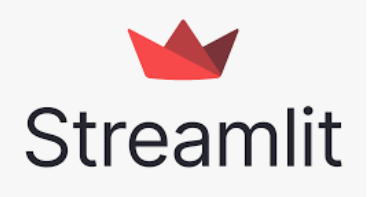

In [ ]:
#Instalar librerías
!pip install streamlit pyngrok pandas matplotlib seaborn openpyxl xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.7 MB/s eta 0:00:00


In [ ]:
#Crear cuenta en ngrok
#https://dashboard.ngrok.com/signup
#Copiar su token
#2FQR9OHFUbOibhYwqpKeH0m280C_6fYLcko4soQU5E1hoLh6J

In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("AQUÍ VA EL TOKEN PERSONAL")

In [ ]:
code = '''
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import io

st.set_page_config(page_title="Análisis de Notas", layout="wide")
st.title("📊 Análisis de Notas de Alumnos")

# Función para generar PDF con gráficos y estadísticas
def generar_pdf(df, col_nota, col_nombre, stats, fig_hist, fig_box, fig_letras, fig_bar):
    buffer = io.BytesIO()
    with PdfPages(buffer) as pdf:
        # Página 1: Estadísticas
        fig_stats, ax_stats = plt.subplots(figsize=(8.5, 15))
        ax_stats.axis('off')
        tabla = stats.to_frame().round(2)
        tabla_texto = tabla.to_string()
        ax_stats.text(0.1, 0.8, tabla_texto, fontsize=12, family='monospace')
        pdf.savefig(fig_stats,bbox_inches='tight')
        plt.close(fig_stats)

        # Página 2: Histogram
        pdf.savefig(fig_hist)
        plt.close(fig_hist)

        # Página 3: Boxplot
        pdf.savefig(fig_box)
        plt.close(fig_box)

        # Página 4: Distribución de letras
        pdf.savefig(fig_letras)
        plt.close(fig_letras)

        # Página 5: Barras por alumno
        pdf.savefig(fig_bar, bbox_inches='tight')
        plt.close(fig_bar)

    buffer.seek(0)
    return buffer

# Subir archivo
uploaded_file = st.file_uploader("📁 Sube tu archivo Excel (.xlsx)", type=["xlsx"])

if uploaded_file is not None:
    df = pd.read_excel(uploaded_file)

    st.subheader("📄 Vista previa de los datos")
    st.dataframe(df)

    columnas_numericas = df.select_dtypes(include='number').columns.tolist()
    columnas_objeto = df.select_dtypes(include='object').columns.tolist()

    if not columnas_numericas:
        st.warning("⚠️ No se encontraron columnas numéricas para analizar.")
    else:
        col_nota = st.selectbox("Selecciona la columna de notas", columnas_numericas)

        st.subheader("📈 Estadísticas Descriptivas")
        stats = df[col_nota].describe()
        st.write(stats)

        # Clasificación por letras
        st.subheader("🎯 Clasificación por letras")
        bins = [0, 10, 13, 16, 18, 20]
        labels = ['E', 'D', 'C', 'B', 'A']
        df['Letra'] = pd.cut(df[col_nota], bins=bins, labels=labels, right=True)
        st.dataframe(df[['Letra']].value_counts().sort_index())

        fig_letras, ax_letras = plt.subplots(figsize=(8.5, 6))
        df['Letra'].value_counts().sort_index().plot(kind='bar', color='orange', ax=ax_letras)
        ax_letras.set_title("Distribución de letras")
        st.pyplot(fig_letras)

        # Histograma
        st.subheader("📊 Histograma de notas")
        fig1, ax1 = plt.subplots(figsize=(8.5, 6))
        sns.histplot(df[col_nota], kde=True, ax=ax1, bins=10)
        st.pyplot(fig1)

        # Boxplot
        st.subheader("📦 Boxplot de notas")
        fig2, ax2 = plt.subplots(figsize=(8.5, 6))
        sns.boxplot(x=df[col_nota], ax=ax2)
        st.pyplot(fig2)

        # Ranking
        if columnas_objeto:
            col_nombre = st.selectbox("Selecciona la columna con nombres", columnas_objeto)

            st.subheader("🏆 Ranking de alumnos")
            top_n = st.slider("Mostrar top N alumnos", 1, len(df), 5)
            ranking = df[[col_nombre, col_nota]].sort_values(by=col_nota, ascending=False).reset_index(drop=True)
            ranking.index += 1
            st.dataframe(ranking.head(top_n))

            # Gráfico de barras
            st.subheader("📌 Notas por alumno")
            fig_bar, ax_bar = plt.subplots(figsize=(8.5, 5))
            sns.barplot(data=ranking.head(top_n), x=col_nombre, y=col_nota, palette="viridis", ax=ax_bar)
            ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45, fontsize=6)
            st.pyplot(fig_bar)

            # Descarga en Excel
            st.subheader("📥 Descargar ranking en Excel")
            output_excel = io.BytesIO()
            with pd.ExcelWriter(output_excel, engine='xlsxwriter') as writer:
                ranking.to_excel(writer, index=True, sheet_name='Ranking')
            st.download_button(
                label="⬇️ Descargar Excel",
                data=output_excel.getvalue(),
                file_name="ranking_notas.xlsx",
                mime="application/vnd.openxmlformats-officedocument.spreadsheetml.sheet"
            )

            # Descarga en PDF
            st.subheader("📄 Descargar reporte en PDF")
            pdf_buffer = generar_pdf(
                df=df,
                col_nota=col_nota,
                col_nombre=col_nombre,
                stats=stats,
                fig_hist=fig1,
                fig_box=fig2,
                fig_letras=fig_letras,
                fig_bar=fig_bar
            )
            st.download_button(
                label="⬇️ Descargar PDF",
                data=pdf_buffer,
                file_name="reporte_notas.pdf",
                mime="application/pdf"
            )

'''

In [ ]:
with open("app.py", "w") as f:
    f.write(code)

In [ ]:
#Levantamos la aplicación
import time
public_url = ngrok.connect(addr="http://localhost:8501", proto="http")
print("Tu app está disponible en:", public_url)
time.sleep(2)
# Ejecutar la app
!streamlit run app.py

Tu app está disponible en: NgrokTunnel: "https://8d22-34-169-153-127.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.169.153.127:8501

/content/app.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ranking.head(top_n), x=col_nombre, y=col_nota, palette="viridis", ax=ax_bar)
/content/app.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45, fontsize=6)
/content/app.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for 